# Regression Analysis on Canadian Rental Data

This notebook performs regression analysis to predict housing prices in Canadian cities based on several features. The analysis includes data cleaning, EDA, and multiple regression models including Linear Regression, Ridge, and Lasso.

## Objectives
- **Understand the dataset:** Perform EDA to explore the distribution of features, correlations, and identify any data quality issues.
- **Data Cleaning:** Handle missing values and prepare the dataset for modeling.
- **Modeling:** Apply and evaluate different regression models to predict rental prices.
- **Model Evaluation:** Use metrics like RMSE and R^2 to evaluate model performance and select the best model.


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder, PolynomialFeatures
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet, RidgeCV, LassoCV, ElasticNetCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.pipeline import Pipeline
import statsmodels.api as sm
from sklearn.pipeline import make_pipeline
sns.set_theme()


In [3]:
# Loading dataset
df = pd.read_csv('./canada_rent.csv')
df.sample(5)

,rentfaster_id,city,province,address,latitude,longitude,lease_term,type,price,beds,baths,sq_feet,link,furnishing,availability_date,smoking,cats,dogs
18246,508629,Ottawa,Ontario,180 Metcalfe Street,45.418785,-75.694099,Long Term,Apartment,2720.0,1 Bed,1,643,/on/ottawa/rentals/apartment/1-bedroom/centret...,Unfurnished,Immediate,Non-Smoking,True,True
6529,568047,Edmonton,Alberta,15661 18 Ave SW,53.416837,-113.595640,Long Term,Duplex,1399.0,2 Beds,1,NaN,/ab/edmonton/rentals/duplex/2-bedrooms/glenrid...,Unfurnished,Immediate,NaN,True,True
5317,517036,Edmonton,Alberta,10110 120 STREET NW,53.541289,-113.529248,Long Term,Apartment,2303.0,2 Beds,2,870,/ab/edmonton/rentals/apartment/1-bedroom/olive...,Unfurnished,Immediate,Non-Smoking,True,True
6938,469680,Edmonton,Alberta,1631 Hammond Crescent NW,53.478893,-113.666089,Long Term,Apartment,2299.0,3 Beds,2.5,0,/ab/edmonton/rentals/apartment/3-bedrooms/hamp...,Unfurnished,Immediate,Non-Smoking,True,True
9398,549948,New Westminster,British Columbia,268 Nelson's Court,49.224863,-122.890570,Long Term,Apartment,2842.0,2 Beds,1,752,/bc/new-westminster/rentals/apartment/1-bedroo...,Unfurnished,Immediate,NaN,True,True


In [4]:
# relevant columns I think are necessary to predict housing prices. 
cols_to_use = ['city', 
               'lease_term', 
               'type', 
               'price', 'beds', 'baths', 'sq_feet', 'furnishing'] #  ,'smoking', 'cats', 'dogs'
df = df[cols_to_use]
df.sample(10)

,city,lease_term,type,price,beds,baths,sq_feet,furnishing
1796,Calgary,Long Term,Condo Unit,1750.0,1 Bed,1,650,Unfurnished
25241,Regina,Long Term,Apartment,1480.0,2 Beds,1,0,Unfurnished
10656,Calgary,Long Term,Condo Unit,1850.0,1 Bed,1,644,Unfurnished
354,Calgary,Long Term,Apartment,2741.0,2 Beds,2,846,Unfurnished
19111,Ottawa,Long Term,Basement,2200.0,2 Beds,1,"1,001",Unfurnished
4622,Calgary,Long Term,Apartment,2100.0,1 Bed,1,510,Furnished
8065,Edmonton,Long Term,Duplex,1400.0,1 Bed,1,600,Unfurnished
7079,Edmonton,Long Term,Duplex,1375.0,1 Bed,1,565,Furnished
7112,Edmonton,Long Term,Apartment,2010.0,2 Beds,2,850,Unfurnished
5433,Edmonton,Long Term,Apartment,1656.0,1 Bed,1,625,Unfurnished


In [5]:
# EDA stuff: Display summary statistics
print(df.sample(2))
print(df.info())
print(df.describe())

         city  lease_term           type   price    beds baths  \
3716  Calgary  Negotiable  Room For Rent   780.0   1 Bed     1   
3602  Calgary   Long Term     Main Floor  2500.0  3 Beds   2.5   

               sq_feet   furnishing  
3716  Approx 450 sq ft    Furnished  
3602              1624  Unfurnished  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25771 entries, 0 to 25770
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   city        25771 non-null  object 
 1   lease_term  25725 non-null  object 
 2   type        25771 non-null  object 
 3   price       25771 non-null  float64
 4   beds        25639 non-null  object 
 5   baths       25637 non-null  object 
 6   sq_feet     21659 non-null  object 
 7   furnishing  25771 non-null  object 
dtypes: float64(1), object(7)
memory usage: 1.6+ MB
None
              price
count  25771.000000
mean    2151.624142
std      972.820941
min        0.000000
25%     1600

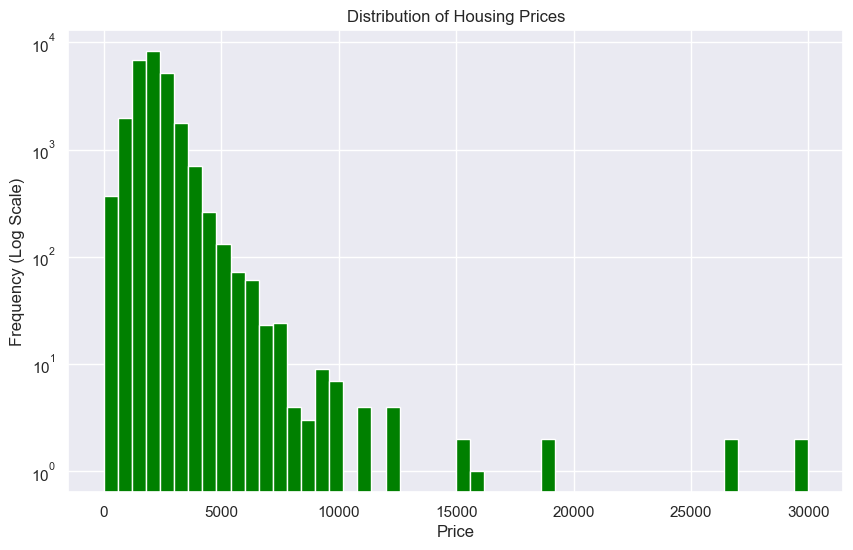

In [6]:
plt.figure(figsize=(10, 6))
plt.hist(df['price'], bins=50, color='green')
plt.yscale('log') 
plt.title('Distribution of Housing Prices')
plt.xlabel('Price')
plt.ylabel('Frequency (Log Scale)')
plt.show()

In [7]:
# Find NAN values
print(df.isna().sum(),'\n')
df.dropna(inplace=True)
print(df.isna().sum())

city             0
lease_term      46
type             0
price            0
beds           132
baths          134
sq_feet       4112
furnishing       0
dtype: int64 

city          0
lease_term    0
type          0
price         0
beds          0
baths         0
sq_feet       0
furnishing    0
dtype: int64


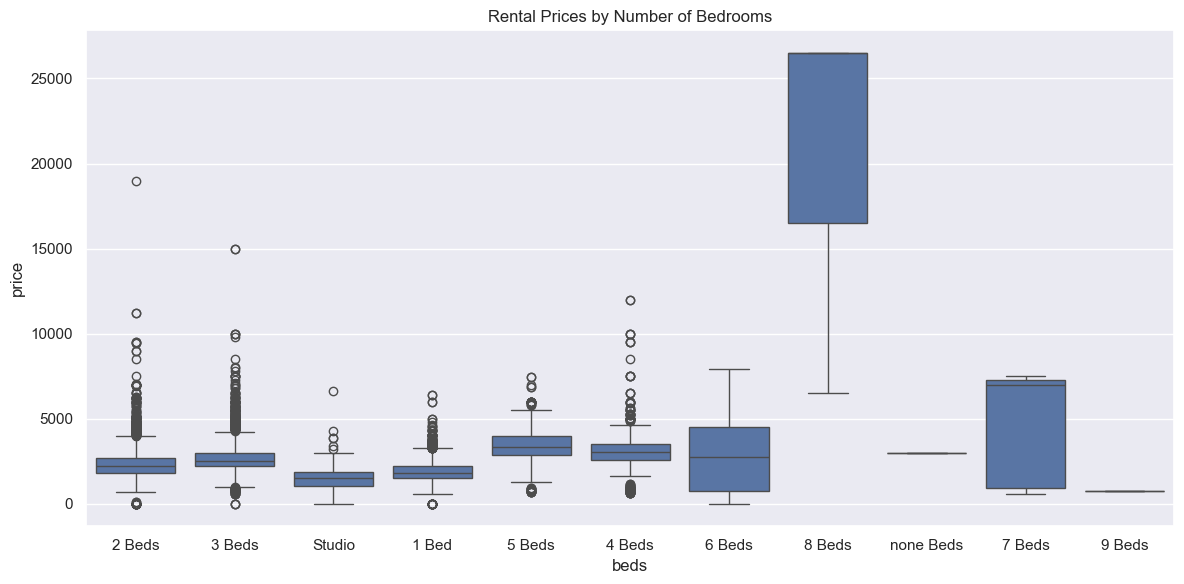

In [8]:
plt.figure(figsize=(12, 6))
sns.boxplot(x='beds', y='price', data=df)
plt.title('Rental Prices by Number of Bedrooms')
plt.tight_layout()
plt.show()

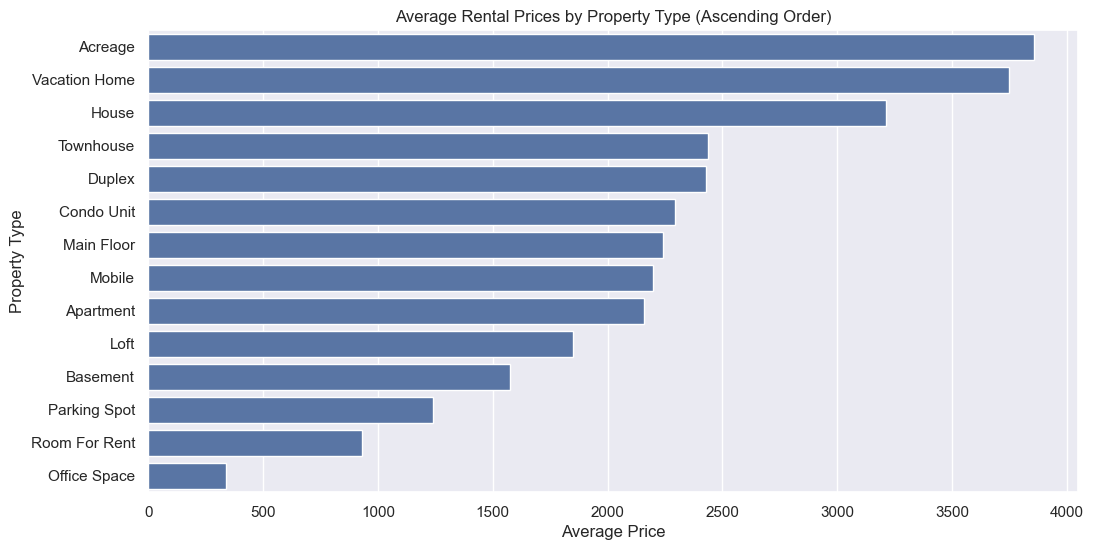

In [9]:
# Calculating average prices by property type
average_prices = df.groupby('type')['price'].mean().sort_values(ascending=False).reset_index()

plt.figure(figsize=(12, 6))
# horizontal bar graph
sns.barplot(x='price', y='type', data=average_prices)  # Note: x and y are swapped for horizontal bars
plt.title('Average Rental Prices by Property Type (Ascending Order)')
plt.xlabel('Average Price')  
plt.ylabel('Property Type')  
plt.show()

# Data Cleaning

In [11]:
# Clean Furnishing column discrepancy
df.loc[df['furnishing'] == 'Unfurnished, Negotiable', 'furnishing'] = 'Negotiable'

# Remove rows where sq_feet is 0
df = df[df['sq_feet'] != 0]

# Clean Baths column
df['baths'] = df['baths'].replace({'none': 0}).astype(float)

# Extract numeric values from sq_feet and handle NaNs
df['sq_feet'] = pd.to_numeric(df['sq_feet'].str.extract(r'(\d+)', expand=False), errors='coerce')
df['sq_feet'] = df['sq_feet'].fillna(df['sq_feet'].median())

# Remove rows where price is 0 or 1
df = df[df['price'] != 0]
df = df[df['price'] != 1]

# Ensure beds column is consistent
df['beds'] = df['beds'].replace({'Studio': '0 Beds'})  # Example of standardizing

In [12]:
df.shape

(21491, 8)

In [13]:
columns_encode = ['city', 'lease_term', 'type', 'beds', 'furnishing'] # encoded
one_hot_encoder = OneHotEncoder(sparse_output=False, drop='first') # OHC with drop='first' to avoid multicollinearity
encoded_columns = one_hot_encoder.fit_transform(df[columns_encode]) # Encode selected columns

# DataFrame of the encoded columns with appropriate column names
encoded_columns_df = pd.DataFrame(encoded_columns, columns=one_hot_encoder.get_feature_names_out(columns_encode))
encoded_columns_df.index = df.index # Ensure the index of the new DataFrame matches the original df
df = pd.concat([df.drop(columns_encode, axis=1), encoded_columns_df], axis=1) # Drop the original columns and concatenate the encoded columns to the original DataFrame

df.sample(5)

,price,baths,sq_feet,city_Airdrie,city_Ajax,city_Aldersyde,city_Amherstview,city_Ancaster,city_Assiniboia,city_Aurora,...,beds_3 Beds,beds_4 Beds,beds_5 Beds,beds_6 Beds,beds_7 Beds,beds_8 Beds,beds_9 Beds,beds_none Beds,furnishing_Negotiable,furnishing_Unfurnished
12073,2950.0,2.0,1125.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
12060,4880.0,3.5,3500.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
25248,2500.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
24473,1939.0,1.0,550.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3754,2100.0,1.5,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [14]:
df.shape

(21491, 278)

# 3 Regression Models:

In [16]:
X = df.drop(columns=['price']) # features
y = df['price'] # target

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# RidgeCV
ridge_cv = RidgeCV(alphas=[0.1, 1.0, 10.0], scoring='neg_mean_absolute_error').fit(X_train, y_train)
best_alpha_ridge = ridge_cv.alpha_

# LassoCV
lasso_cv = LassoCV(alphas=[0.1, 1.0, 10.0], max_iter=10000).fit(X_train, y_train)
best_alpha_lasso = lasso_cv.alpha_

# ElasticNetCV
elastic_net_cv = ElasticNetCV(l1_ratio=[0.1, 0.5, 0.9], alphas=[0.1, 1.0, 10.0], max_iter=10000, cv=5).fit(X_train, y_train)

# Predict on test 
y_pred_ridge = ridge_cv.predict(X_test)
y_pred_lasso = lasso_cv.predict(X_test)
y_pred_enet = elastic_net_cv.predict(X_test)

# Calculate RMSE and R^2 for each 
rmse_ridge = np.sqrt(mean_squared_error(y_test, y_pred_ridge))
r2_ridge = r2_score(y_test, y_pred_ridge)

rmse_lasso = np.sqrt(mean_squared_error(y_test, y_pred_lasso))
r2_lasso = r2_score(y_test, y_pred_lasso)

rmse_enet = np.sqrt(mean_squared_error(y_test, y_pred_enet))
r2_enet = r2_score(y_test, y_pred_enet)

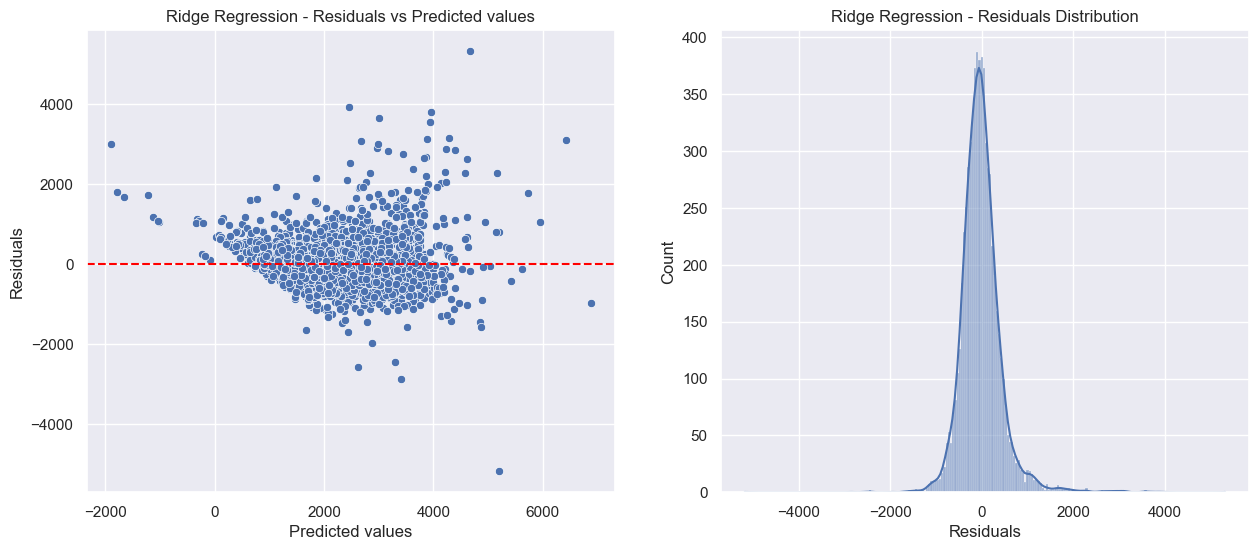

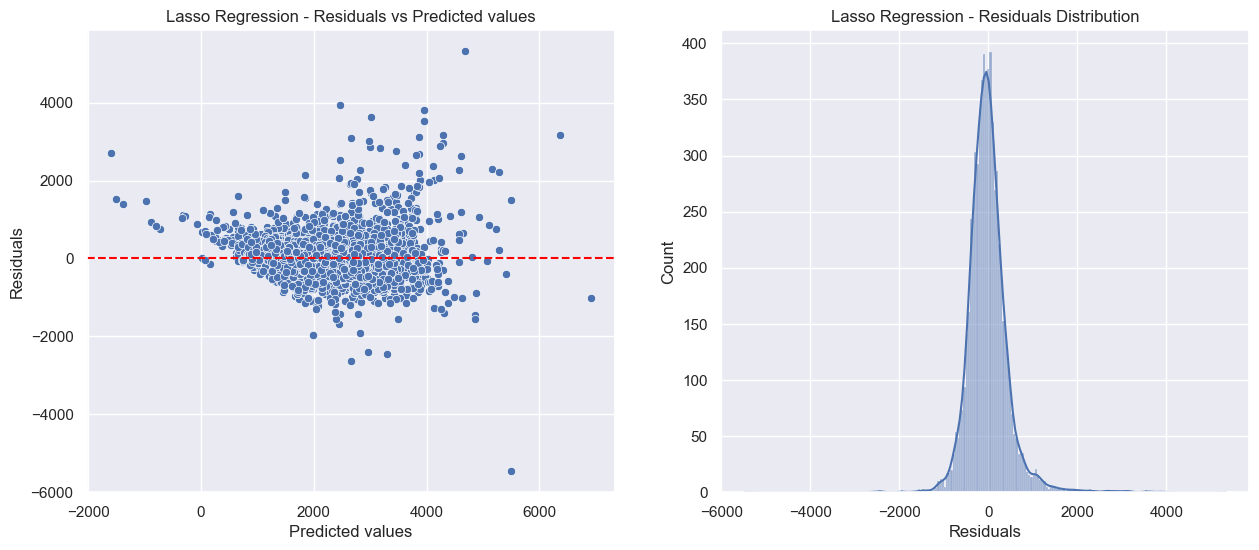

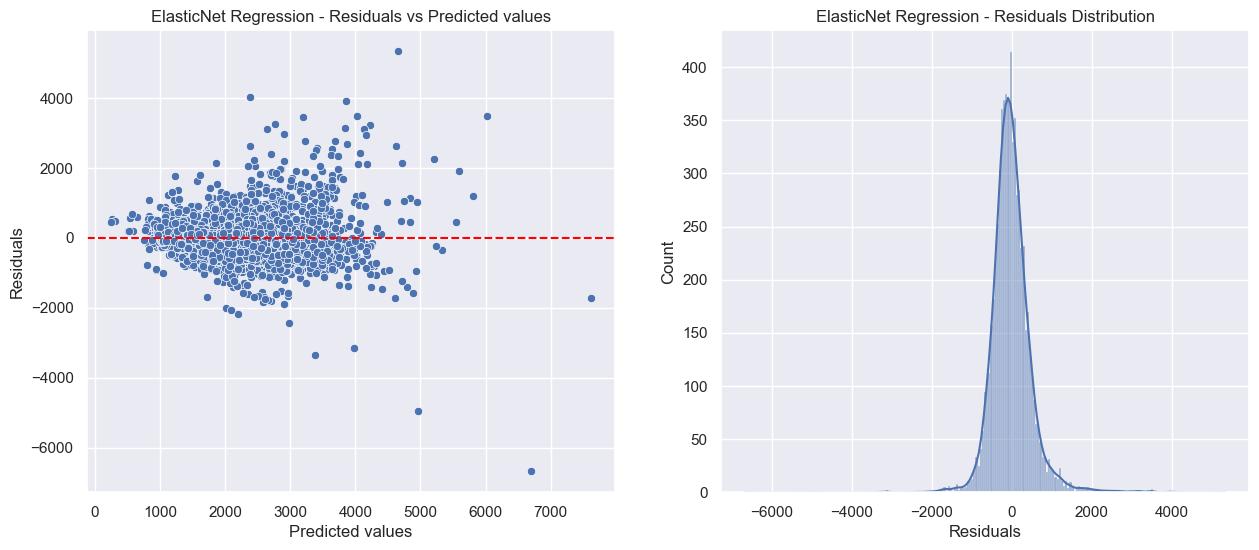

In [17]:
# Function to plot residuals
def plot_residuals(y_true, y_pred, model_name):
    residuals = y_true - y_pred
    plt.figure(figsize=(15, 6))
    
    # Residuals vs Predicted values
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=y_pred, y=residuals)
    plt.axhline(0, color='red', linestyle='--')
    plt.xlabel('Predicted values')
    plt.ylabel('Residuals')
    plt.title(f'{model_name} - Residuals vs Predicted values')

    # Histogram of residuals
    plt.subplot(1, 2, 2)
    sns.histplot(residuals, kde=True)
    plt.xlabel('Residuals')
    plt.title(f'{model_name} - Residuals Distribution')
    plt.show()

# Function to plot actual vs. predicted values
def plot_actual_vs_predicted(y_true, y_pred, model_name):
    plt.figure(figsize=(7, 6))
    sns.scatterplot(x=y_true, y=y_pred)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], color='red', linestyle='--')
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'{model_name} - Actual vs Predicted')
    plt.show()

# Plot residuals and actual vs predicted for each model
plot_residuals(y_test, y_pred_ridge, 'Ridge Regression')
plot_residuals(y_test, y_pred_lasso, 'Lasso Regression')
plot_residuals(y_test, y_pred_enet, 'ElasticNet Regression')

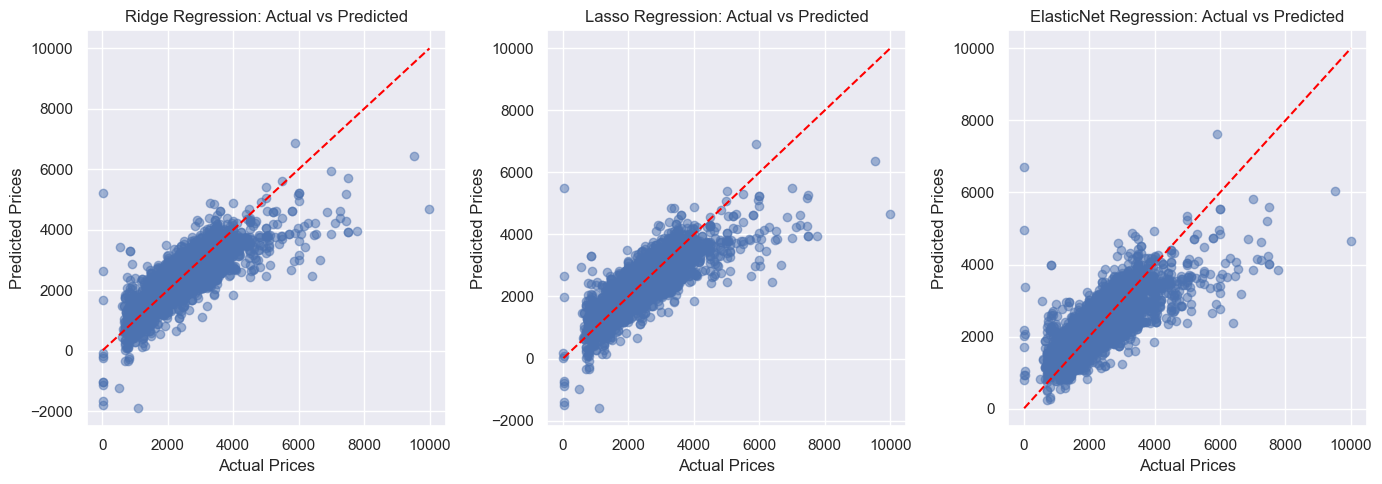

Ridge Regression: Best alpha = 0.1, RMSE = 455.03, R^2 = 0.70
Lasso Regression: Best alpha = 0.1, RMSE = 456.52, R^2 = 0.70
ElasticNet Regression: RMSE = 505.00, R^2 = 0.63


In [18]:
# Actual vs. Predicted Plots
plt.figure(figsize=(14, 5))

# Ridge
plt.subplot(1, 3, 1)
plt.scatter(y_test, y_pred_ridge, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Ridge Regression: Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# Lasso
plt.subplot(1, 3, 2)
plt.scatter(y_test, y_pred_lasso, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('Lasso Regression: Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

# ElasticNet
plt.subplot(1, 3, 3)
plt.scatter(y_test, y_pred_enet, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], color='red', linestyle='--')
plt.title('ElasticNet Regression: Actual vs Predicted')
plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')

plt.tight_layout()
plt.show()

print(f'Ridge Regression: Best alpha = {best_alpha_ridge}, RMSE = {rmse_ridge:.2f}, R^2 = {r2_ridge:.2f}')
print(f'Lasso Regression: Best alpha = {best_alpha_lasso}, RMSE = {rmse_lasso:.2f}, R^2 = {r2_lasso:.2f}')
print(f'ElasticNet Regression: RMSE = {rmse_enet:.2f}, R^2 = {r2_enet:.2f}')

In [19]:
# Ridge Regression: Best alpha = 0.1, RMSE = 455.03, R^2 = 0.70
# Lasso Regression: Best alpha = 0.1, RMSE = 456.52, R^2 = 0.70
# ElasticNet Regression: RMSE = 505.00, R^2 = 0.63

In [20]:
# RidgeCV RMSE of 455.03 and R^2 %70, strong predictive performance and able to explain 70% of variance in price.
# LassoCV RMSE of 456.52 and an R^2 of %70, similar predictive score to RidgeCV
# ElasticNetCV RMSE of 505.00 and an R^2 of %63, weaker predictive performance compared to both Ridge and Lasso models.

### Prediction: Using RidgeCV

In [22]:
# Fit the model on the entire dataset
ridge_cv.fit(X, y)

# Predicting new input data
new_data = pd.DataFrame({
    'city': ['Toronto'],
    'lease_term': ['Long Term'],
    'type': ['Apartment'],
    'beds': ['2 Beds'],
    'baths': ['1 Bath'],
    'sq_feet': ['850'],
    'furnishing': ['Furnished']
})

# One-hot encoding for new data
new_data_encoded = pd.get_dummies(new_data, drop_first=True).reindex(columns=X.columns, fill_value=0)

# Make prediction
predicted_price = ridge_cv.predict(new_data_encoded)
print(f"Predicted Price: {predicted_price[0]}")

Predicted Price: 1898.08012572482


# The End!